In [ ]:
from google.colab import files, drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#**Data preprocessing**

In [ ]:
import numpy as np
import os, sys 
from sklearn.feature_extraction.text import TfidfVectorizer

## using `TfidfVectorizer` from sklearn to generate tf-idf values for every word in each document.

pos_reviews_dir = '/content/drive/My Drive/reviews/pos/'
neg_reviews_dir = '/content/drive/My Drive/reviews/neg/'
pos_reviews_files = os.listdir(pos_reviews_dir)
neg_reviews_files = os.listdir(neg_reviews_dir)

## please set `max_features` to 200 when you build the tfidf vectorizer, meaning that we only use
## top 200 words to form our vocabulary V.
max_features=200

text_corpus=[]
labels=[]

## read 500 documents from positive reviews and another 500 documents from negative reviews (you are
## allowed to read more documents).

for i in range(500):
  f=pos_reviews_files[i]
  with open(pos_reviews_dir+f) as fheader:
    text_corpus.append(fheader.read().replace('\n',''))
    labels.append([1,0])
for i in range(500):
  f=neg_reviews_files[i]
  with open(neg_reviews_dir+f) as fheader:
    text_corpus.append(fheader.read().replace('\n',''))
    labels.append([0,1])

vectorizer=TfidfVectorizer(max_features=max_features,stop_words='english')
x=vectorizer.fit_transform(text_corpus)
y=np.array(labels)
print(x.shape,y.shape)

(1000, 200) (1000, 2)


In [ ]:
## In this section, you need to construct the training set (#documents,#max_length_among_documents,
## Vocabulary_size)
## For each word in a document, you use the onehot encoding-like vector representation except that
## we use the tfidf value calculated in the previous step if that word appears in that document,
## rather than 1. The dimension of this vector is the size of the vocabulary. For example, if a word w
## in document d is the 3rd word in the vocabulary, this word is represented as (0,0,tfidf(w,d),0,0,...0).
## If the length of a document (l) is less than the max_length(L), word 1, word 2, ..., word L-l are
## represented as zero vectors (0,0,...,0).
## Meanwhile, you also need to generate labels (#documents, 2) since this is a binary classification
## problem.

import torch
from sklearn.model_selection import train_test_split

seq_length=-1

tokenizer=vectorizer.build_tokenizer()
vocab=vectorizer.vocabulary_
#print(vocab)
docs_tokens = [tokenizer(doc) for doc in text_corpus]
#print(len(docs_tokens[0]))
docs = []
for i in range(len(docs_tokens)):
  terms=[]
  for j in range(len(docs_tokens[i])):
    w=docs_tokens[i][j]
    if w in vocab:
      terms.append(w)
  #print(seq_length)
  if len(terms)>seq_length:
    seq_length=len(terms)
  docs.append(terms)

datasets=np.zeros([x.shape[0],seq_length,max_features])

for i in range(len(docs)): 
  n_padding = seq_length - len(docs[i])

  for j in range(len(docs[i])): 
    w=docs[i][j]
    feature_idx=vocab[w]
    #print(idx)
    tfidf_val=x[i,feature_idx]
    datasets[i,j+n_padding,feature_idx]=tfidf_val
datasets = datasets.astype(np.float32)
y=y.astype(np.float32)

x_train,x_val,y_train,y_val = train_test_split(datasets,y,test_size=0.2,random_state=1996)
print(x_train.shape,y_train.shape,x_val.shape,y_val.shape)

(800, 258, 200) (800, 2) (200, 258, 200) (200, 2)


#**Data Loaders**

In [ ]:
## Create train loader and validation loader
from torch.utils.data import DataLoader, TensorDataset
batch_size=16
train_data=TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train) )
val_data=TensorDataset(torch.from_numpy(x_val),torch.from_numpy(y_val) )

train_loader=DataLoader(train_data,batch_size=batch_size,shuffle=True)
val_loader=DataLoader(val_data,batch_size=batch_size,shuffle=True)

#**Model: a general framework for multi-layer RNN**          
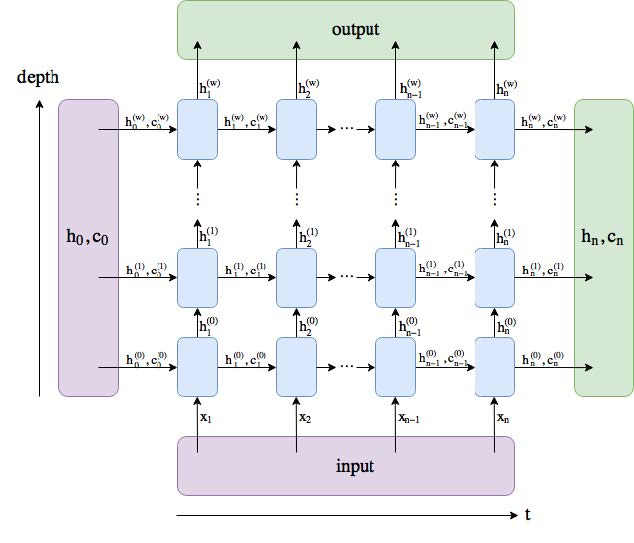

In [ ]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class Model(nn.Module):
  def __init__(self, input_size, output_size, hidden_size, n_layers):
    super().__init__()
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.rnn = nn.RNN(input_size,hidden_size,n_layers,batch_first=True) # rnn layer
    self.fc1 = nn.Linear(hidden_size,output_size) # rnn output (y_t) --> output (y'_t)
    self.fc2 = nn.Linear(output_size,2) #the output from the last time period ->sentiment prediction
  def forward(self,x, hidden):
    batch_size = x.size()[0]
    hidden = self.init_hidden(batch_size)
    rnn_out,hidden = self.rnn(x,hidden)
    rnn_out = self.fc1(rnn_out)
    last_out = rnn_out[:,-1,:].view(batch_size,-1)
    out = F.softmax(self.fc2(last_out))
    return out,hidden
  def init_hidden(self,batch_size):
    hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size)#.cuda()
    return hidden
model = Model(200,32,256,3)
print(model)

Model(
  (rnn): RNN(200, 256, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=256, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=2, bias=True)
)


#**Training and Validation**


In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  model.to(device)

#hyperparameters
epochs=5
learning_rate=1e-4
count=0

#loss function and optimizer
criterion=nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(epochs):
  #hidden state initialization
  h=model.init_hidden(batch_size)

  for inputs, labels in train_loader:
    count+=1
    inputs, labels =inputs.to(device), labels.to(device)

    optimizer.zero_grad() 

    predicted_outputs, h = model(inputs, h)
    loss = criterion(predicted_outputs, torch.max(labels,1)[1])
    loss.backward()

    
    optimizer.step()

    val_h =model.init_hidden(batch_size)#.cuda()
    val_losses=[]

    model.eval()

    for inputs, labels in val_loader:
      inputs, labels =inputs.to(device), labels.to(device)
      val_outputs, val_h = model(inputs, val_h)
      val_loss = criterion(val_outputs, torch.max(labels,1)[1])
      val_losses.append(val_loss.item())
      
    model.train()

    print('Epoch: %d '%(epoch+1),
            'Batch: %d '%count,
            'Training loss: %.4f'%(loss.item()),
            'Validation loss: %.4f'%(np.mean(val_losses)))

      
  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1  Batch: 1  Training loss: 0.6185 Validation loss: 0.7279
Epoch: 1  Batch: 2  Training loss: 0.6579 Validation loss: 0.7302
Epoch: 1  Batch: 3  Training loss: 0.6071 Validation loss: 0.7315
Epoch: 1  Batch: 4  Training loss: 0.6413 Validation loss: 0.7285
Epoch: 1  Batch: 5  Training loss: 0.6654 Validation loss: 0.7221
Epoch: 1  Batch: 6  Training loss: 0.5724 Validation loss: 0.7203
Epoch: 1  Batch: 7  Training loss: 0.6635 Validation loss: 0.7304
Epoch: 1  Batch: 8  Training loss: 0.6515 Validation loss: 0.7244
Epoch: 1  Batch: 9  Training loss: 0.5353 Validation loss: 0.7200
Epoch: 1  Batch: 10  Training loss: 0.6067 Validation loss: 0.7287
Epoch: 1  Batch: 11  Training loss: 0.7227 Validation loss: 0.7199
Epoch: 1  Batch: 12  Training loss: 0.6810 Validation loss: 0.7238
Epoch: 1  Batch: 13  Training loss: 0.6716 Validation loss: 0.7205
Epoch: 1  Batch: 14  Training loss: 0.5586 Validation loss: 0.7168
Epoch: 1  Batch: 15  Training loss: 0.6683 Validation loss: 0.7243
Epoc